In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from transformers import BertTokenizer, AutoAdapterModel, AdapterConfig
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score
import os
import warnings
warnings.filterwarnings('ignore')

/opt/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
file_path = r"../datasets/"
train_file = r"train.csv"
test_file = r"test.csv"
subm_file = r"sample_submission.csv"

raw_train_data = pd.read_csv(file_path+train_file)
raw_test_data = pd.read_csv(file_path+test_file)

raw_train_data.shape

(7613, 5)

In [3]:
max_length = 0
count = 0
for i in range(0, raw_train_data.shape[0]):
    length = len(raw_train_data['text'].iloc[i])
    if length > max_length:
        max_length = length
    if length > 128:
        count += 1
count

2356

<Axes: >

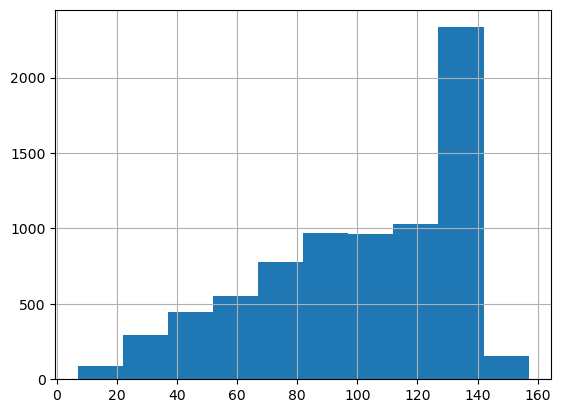

In [16]:
raw_train_data['text'].apply(lambda x: len(x)).hist()

In [4]:
# Tokenize the text using BERT's tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Tokenize the text using BERT's tokenizer and ensure uniform sequence length
max_sequence_length = 128  # Adjust to an appropriate sequence length

raw_train_data['text'] = raw_train_data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_sequence_length, truncation=True, padding='max_length'))
raw_test_data['text'] = raw_test_data['text'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=max_sequence_length, truncation=True, padding='max_length'))
raw_train_data['text'].head()

0    [101, 2256, 15616, 2024, 1996, 3114, 1997, 202...
1    [101, 3224, 2543, 2379, 2474, 6902, 3351, 2187...
2    [101, 2035, 3901, 2356, 2000, 1005, 7713, 1999...
3    [101, 2410, 1010, 2199, 2111, 4374, 1001, 3748...
4    [101, 2074, 2288, 2741, 2023, 6302, 2013, 1009...
Name: text, dtype: object

In [5]:
# Split the data into train and train sets
# train : val : test = 70% : 15% : 15%
train_data, test_data, train_labels, test_labels = train_test_split(raw_train_data['text'], raw_train_data['target'], test_size=0.3, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(raw_train_data['text'], raw_train_data['target'], test_size=0.5, random_state=42)

train_data = torch.LongTensor(train_data.tolist())
train_labels = torch.LongTensor(train_labels.tolist())
val_data = torch.LongTensor(val_data.tolist())
val_labels = torch.LongTensor(val_labels.tolist())
test_data = torch.LongTensor(test_data.tolist())
test_labels = torch.LongTensor(test_labels.tolist())

In [6]:
# Create PyTorch datasets and dataloaders
class DisasterDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
train_dataset = DisasterDataset(train_data, train_labels)
val_dataset = DisasterDataset(val_data, val_labels)
test_dataset = DisasterDataset(test_data, test_labels)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [7]:
class DisasterClassifier(nn.Module):
    def __init__(self):
        super(DisasterClassifier, self).__init__()
        
        self.bert = AutoAdapterModel.from_pretrained('bert-base-uncased')
        for param in self.bert.parameters():
            param.requires_grad = False
        # Load pre-trained task adapter from Adapter Hub
        # This method call will also load a pre-trained classification head for the adapter task  
        
        # https://github.com/adapter-hub/adapter-transformers/blob/master/adapter_docs/prediction_heads.md
        self.bert_out_dim = 32
        self.bert.add_classification_head("mrpc", num_labels=self.bert_out_dim)
        
        self.bert.add_adapter("mrpc", config="pfeiffer")
        self.bert.set_active_adapters("mrpc")
        
        # check the reduction factor for "sentiment/sst-2@ukp": https://adapterhub.ml/adapters/ukp/bert-base-uncased_sentiment_sst-2_pfeiffer/
        # bert output dimension = 786/reduction factor
        self.adpter_reduction_factor = 16
        # self.dimension_reduce_layer = nn.Linear(int(768/self.adpter_reduction_factor), 64)  # Reduce BERT's output dimension
        self.dimension_reduce_layer = nn.Linear(self.bert_out_dim, 64)
        
        self.mlp = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(8, 2)  # 2 classes: real disaster or not
        )

    def forward(self, input_ids):
        outputs = self.bert(input_ids)
        pooled_output = outputs['logits']
        pooled_output = self.dimension_reduce_layer(pooled_output)
        logits = self.mlp(pooled_output)
        return logits

In [9]:
EXPERIMENT_ID = 2
EPOCH = 20

path_checkpoint = f'../model/checkpoint/ckpt_expr_{EXPERIMENT_ID}.pth'

start_epoch = -1

model = DisasterClassifier()
# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

if os.path.exists(path_checkpoint):
    print('load model...')
    checkpoint = torch.load(path_checkpoint)  # 加载断点
    model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数
    optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
    start_epoch = checkpoint['epoch']  # 设置开始的epoch

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertAdapterModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertAdapterModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertAdapterModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [10]:
iepoches = []
f1_vals = []

# Training loop
for iepoch in range(start_epoch + 1 ,EPOCH):
    print(f'train epoch {iepoch}/{EPOCH}')
    model.train()
    for data, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # save model
    checkpoint = {
            "net": model.state_dict(),
            'optimizer':optimizer.state_dict(),
            "epoch": iepoch
        }
    if not os.path.isdir("../model/checkpoint"):
        os.mkdir("../model/checkpoint")
    torch.save(checkpoint, f'../model/checkpoint/ckpt_expr_{EXPERIMENT_ID}.pth')
        
    # Validation loop
    if iepoch % 2 == 0:
        model.eval()
        
        # validate
        predicted_labels = []
        true_labels = []
        with torch.no_grad():
            for data, labels in tqdm(val_loader):
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                predicted_labels.extend(predicted.tolist())
                true_labels.extend(labels.tolist())
                
        f1 = f1_score(true_labels, predicted_labels, average='macro')
        
        iepoches.append(iepoch)
        f1_vals.append(f1)
        print(f'Validation F1 Score: {f1 * 100:.2f}%')
        
        # test
        predicted_labels = []
        true_labels = []
        with torch.no_grad():
            for data, labels in tqdm(test_loader):
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                predicted_labels.extend(predicted.tolist())
                true_labels.extend(labels.tolist())
                
        f1 = f1_score(true_labels, predicted_labels, average='macro')
        
        iepoches.append(iepoch)
        f1_vals.append(f1)
        print(f'Test F1 Score: {f1 * 100:.2f}%')

train epoch 0/20


100%|██████████| 119/119 [00:49<00:00,  2.38it/s]


Validation F1 Score: 83.11%


100%|██████████| 119/119 [00:34<00:00,  3.42it/s]


Test F1 Score: 82.42%
train epoch 1/20


100%|██████████| 167/167 [02:21<00:00,  1.18it/s]


train epoch 2/20


100%|██████████| 119/119 [00:47<00:00,  2.49it/s]


Validation F1 Score: 86.19%


100%|██████████| 119/119 [00:41<00:00,  2.86it/s]


Test F1 Score: 84.15%
train epoch 3/20


100%|██████████| 167/167 [02:18<00:00,  1.20it/s]


train epoch 4/20


100%|██████████| 119/119 [00:48<00:00,  2.44it/s]


Validation F1 Score: 86.48%


100%|██████████| 119/119 [00:50<00:00,  2.38it/s]


Test F1 Score: 83.03%
train epoch 5/20


100%|██████████| 167/167 [02:21<00:00,  1.18it/s]


train epoch 6/20


100%|██████████| 119/119 [00:51<00:00,  2.30it/s]


Validation F1 Score: 89.49%


100%|██████████| 119/119 [00:48<00:00,  2.44it/s]


Test F1 Score: 81.65%
train epoch 7/20


100%|██████████| 167/167 [02:28<00:00,  1.13it/s]


train epoch 8/20


100%|██████████| 119/119 [00:49<00:00,  2.39it/s]


Validation F1 Score: 93.51%


100%|██████████| 119/119 [00:49<00:00,  2.41it/s]


Test F1 Score: 86.53%
train epoch 9/20


100%|██████████| 167/167 [02:25<00:00,  1.15it/s]


train epoch 10/20


100%|██████████| 119/119 [00:49<00:00,  2.41it/s]


Validation F1 Score: 94.21%


100%|██████████| 119/119 [00:49<00:00,  2.42it/s]


Test F1 Score: 85.46%
train epoch 11/20


100%|██████████| 167/167 [02:25<00:00,  1.15it/s]


train epoch 12/20


100%|██████████| 119/119 [00:49<00:00,  2.42it/s]


Validation F1 Score: 96.47%


100%|██████████| 119/119 [00:49<00:00,  2.41it/s]


Test F1 Score: 87.55%
train epoch 13/20


100%|██████████| 167/167 [02:25<00:00,  1.15it/s]


train epoch 14/20


100%|██████████| 119/119 [00:50<00:00,  2.35it/s]


Validation F1 Score: 97.56%


100%|██████████| 119/119 [00:38<00:00,  3.06it/s]


Test F1 Score: 88.04%
train epoch 15/20


100%|██████████| 167/167 [02:18<00:00,  1.21it/s]


train epoch 16/20


100%|██████████| 119/119 [00:47<00:00,  2.49it/s]


Validation F1 Score: 96.74%


100%|██████████| 119/119 [00:48<00:00,  2.43it/s]


Test F1 Score: 85.73%
train epoch 17/20


100%|██████████| 167/167 [02:24<00:00,  1.16it/s]


train epoch 18/20


100%|██████████| 119/119 [00:49<00:00,  2.39it/s]


Validation F1 Score: 97.30%


100%|██████████| 119/119 [00:50<00:00,  2.35it/s]


Test F1 Score: 86.73%
train epoch 19/20


100%|██████████| 167/167 [02:25<00:00,  1.15it/s]


In [11]:
predicted_labels = []
true_labels = []
with torch.no_grad():
    for data, labels in tqdm(test_loader):
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())
                
f1 = f1_score(true_labels, predicted_labels, average='macro')

100%|██████████| 119/119 [00:53<00:00,  2.24it/s]


In [13]:
f1

0.857121251375683

# Analyze

In [ ]:
raw_train_data['text'].iloc[2]

"All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"

In [ ]:
# check if the sample is balanced
n_p_sample = raw_train_data[raw_train_data['target'] == 1].shape[0]
n_sample = raw_train_data.shape[0]
perc_p_sample = n_p_sample/n_sample
perc_p_sample

0.4296597924602653

The training sample is kind of balanced

In [29]:
# number of different location
raw_train_data['location'].unique()

3342

array([[<Axes: title={'center': 'id'}>]], dtype=object)

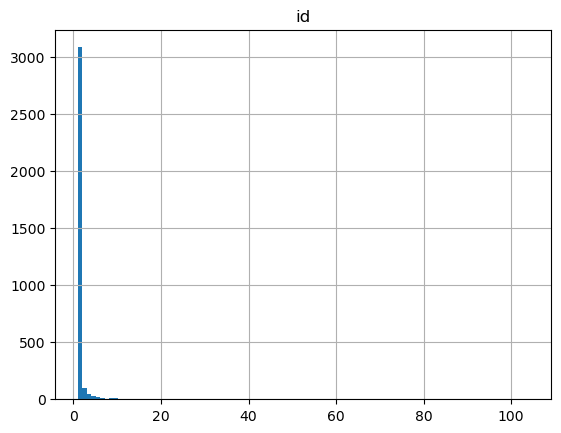

In [35]:
# number of disaster tweets in each location
raw_train_data[['location', 'id']].groupby('location').count().hist(bins=100)

In [36]:
# data cleaning 
raw_train_data["text"]

0       Our Deeds are the Reason of this #earthquake M...
1                  Forest fire near La Ronge Sask. Canada
2       All residents asked to 'shelter in place' are ...
3       13,000 people receive #wildfires evacuation or...
4       Just got sent this photo from Ruby #Alaska as ...
                              ...                        
7608    Two giant cranes holding a bridge collapse int...
7609    @aria_ahrary @TheTawniest The out of control w...
7610    M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...
7611    Police investigating after an e-bike collided ...
7612    The Latest: More Homes Razed by Northern Calif...
Name: text, Length: 7613, dtype: object

In [ ]:
X = raw_train_data["text"]
y = raw_train_data["target"]
# X represents your features, and y represents your labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)